# Model of Track's Similarity Matrix

## Based on the article [Steffen Pauws and Berry Eggen](http://ismir2002.ircam.fr/proceedings/OKPROC02-FP07-4.pdf)

The main idea is to establish a metric and build a similarity matrix indicating the probabilitity thet two songs are the same. This will be done using the track's features, track's metadata and the playlists built by the users on Spotify.  

In [1]:
# Importing libraries 
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import train_test_split

from seaborn import heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob
import os

## Defining Important Features 

This features will be used to understand the data. We separate the metadata and audio features needed in the process. These features are obtained from Spotify API

In [2]:
metadata =  ['playlist_id', 'explicit', 'id', 'popularity', 'album_id', 
             'album_release_date', 'artists_ids']
audio_features = ['danceability', 'energy', 'loudness', 'key', 'mode', 'speechiness', 'acousticness', 
                  'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_ms', 'id']

## Playlist and Tracks dataframes 

Here we get the playlists, the audio features and the tracks. I separate playlists with more the 5 tracks and less than 500, due to computational problems and considering that people do not make playlists of this size. 

I will only consider a random part of the dataset, due to computational costs. 

In [3]:
sample = 0.2
playlists_df = pd.read_pickle('../data/sp_playlists.pkl')[['id', 'tracks']]
playlists_df.rename(columns = {'id': 'playlist_id', 'tracks': 'n_tracks'}, inplace = True)

playlists_df.n_tracks = playlists_df.n_tracks.apply(lambda x: x['total'])

# Getting Playlists with at least 5 tracks and maximum of 500 tracks
playlists_df = playlists_df[(playlists_df.n_tracks >= 5) & (playlists_df.n_tracks <= 500)].sample(frac = sample, 
                                                                                                 random_state = 100)

del playlists_df['n_tracks']

In [4]:
audio_features_df = pd.read_pickle('../data/sp_audio_features.pkl')[audio_features]

tracks_df = pd.DataFrame()
for file in tqdm(glob.glob('../data/sp_tracks_ready_*.pkl')):
    a = pd.read_pickle(file)[metadata]
    a = a[a.playlist_id.isin(playlists_df.playlist_id)]
    tracks_df = pd.concat([tracks_df, a], ignore_index = True)

tracks_df = tracks_df.merge(audio_features_df, on = 'id')

del audio_features_df
del a

## Treating the data

I convert the dates to datetime and use the year as a continuum value. 

In [5]:
tracks_df['album_release_date'].replace(to_replace = '0000', value = None, inplace=True)
tracks_df['album_release_date'] = pd.to_datetime(tracks_df['album_release_date'], errors = 'coerce')
tracks_df['album_release_date'] = (tracks_df['album_release_date'] - tracks_df['album_release_date'].min())
tracks_df['days'] = tracks_df['album_release_date']/np.timedelta64(1,'D')

We have some few nan values in the `column days`. I will put the mean of the values, because it's few missing data. It will depend on the initial sample. 

In [6]:
tracks_df['days'].fillna(np.mean(tracks_df['days']), inplace = True)

Convert the artists to set, in order to the metric presented below. It helps the analysis. 

In [7]:
tracks_df.artists_ids = tracks_df.artists_ids.apply(set)

I separate the categorical, numerical and set oriented features, to make the ideia of the similarity matrix. This ideia is withdrawn from article already cited.  

In [8]:
features_categorical =  ['explicit', 'album_id', 'key', 'mode', 'time_signature']
features_numerical = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'days']
features_set_oriented = ['artists_ids']

features = [] 
features.extend(features_categorical)
features.extend(features_numerical)
features.extend(features_set_oriented)

Only to ensure correct type of numerical features. 

In [9]:
tracks_df[features_numerical] = tracks_df[features_numerical].astype(float)

## Defining the metric

Let's build the metrics proposed. For now, I normalize the numerical data, ensuring the range to be $[0,1]$. This ensures the metric works.

Consider $w$ a weight vector with size $K$, the number of features and $||w||_1 = 1$. Consider we have $r, s$ and $t$ features categorical, numerical and set_oriented, respectively, where $r + s + t = K$. Let $x$ e $y$ be two tracks. So:

$$S = \sum_{i=1}^r w_i(\mathbb{1}\{x_i = y_i\}) + \sum_{j = 1}^s w_{r + j}(1 - ||x_j - y_j||_1) + \sum_{k=1}^t w_{r + s + k} \frac{|x_k \cap y_k|}{|x_k \cup y_k|}$$ 

In [10]:
scaler = MinMaxScaler()
tracks_df[features_numerical] = scaler.fit_transform(tracks_df[features_numerical])

I will give grades of importance (1 - 5) based on my experience to each feature. This can be changed, however it will change how the model give importance for each feature in simmilarity calculation.

In [13]:
metric_categorical = lambda x1,x2:  x1 == x2
metric_set_oriented = lambda x1, x2: len(x1 & x2)/(len(x1.union(x2)))
metric_numerical = lambda x1, x2: 1 - abs(x1 - x2)

weights = [1, 5, 2, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5]
weights = np.array(weights)/sum(weights)

def metric_songs(x: np.array, y: np.array) -> float: 
    
    similarity = 0
    similarity += np.dot(weights[0:5], metric_categorical(x[0:5], y[0:5]))
    similarity += np.dot(weights[5:17], metric_numerical(x[5:17], y[5:17]))
    similarity += weights[17]*metric_set_oriented(x[17], y[17])

    return similarity

## Simple example

Let's calculate a simple case with 500 songs.

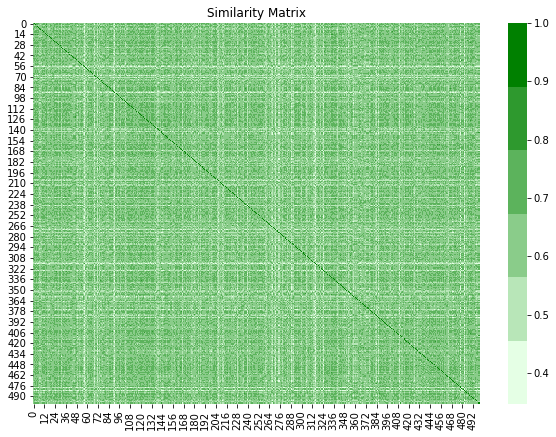

In [14]:
x1 = np.array(tracks_df.drop_duplicates('id')[features].sample(500))
matrix = cdist(x1, x1, metric = metric_songs)

fig, ax = plt.subplots(figsize = (10,7))
heatmap(matrix, ax = ax, cmap = sns.light_palette("green"))
ax.set_title('Similarity Matrix')

plt.show()

## Recommendation based on similarity. 

We will use the metric described above. The similarity between two songs will be interpreted as a **probability**. We could build the role track similarity but it requires much computation. So we will do a simple modification. We will calculate the metric between two songs if they are in the same playlist, for some playlist in the dataset. We expect it reduces the number of calculations! 

After we will have a sparser matrix and in order too add tracks to a playlist, we get $n$ tracks that maximize the mean probability on the similarity matrix, but considering only the tracks on the playlist given.  

If two tracks appear in the same playlists more times, we use a correction factor. We do as below, if $x$ is the similarity between two tracks, I want $f$ factor that: 

$$x \leq fx < 1 \implies 1 \leq f < \frac{1}{x}$$

I take $f$ as a convex combination of the values. So: 

$$f = \alpha + \frac{1 - \alpha}{x} \implies fx = \alpha x + (1 - \alpha),$$

where $\alpha \in (0,1]$. If $\alpha = 1$, we do not have this correction. 

## Evaluation 

### R-precision metric

As described in their work, [Chen et al.](https://dl.acm.org/doi/10.1145/3240323.3240342) suggests a metric for playlist continuation evaluation. They call it **R-precision**. It measures how many of the real tracks (and their artists) the model suggested correctly.

A playlist as input to the model has two parts: its part on display to the model and it's hidden part. The hidden part is what the model try to predict and is called *ground truth*.

$$\textrm{R-precision} = \dfrac{|S_T \cap G_T| + 0.25 \cdot |S_A \cap G_A|}{|G_T|}$$

$G_T$ is the set of unique track IDs from ground truth, that is, the unique hidden tracks. $S_T$ is the suggested tracks from our model. $G_A$ is the set of unique artists IDs from ground truth and $S_A$ is the set of predicted artists. The metric can be interpreted as accuracy (although it can be greater than 1), but giving some score for wrong tracks with right artists.

In [19]:
# Class of the model

class SimilarityModel:
    
    def __init__(self, tracks: pd.DataFrame, playlists: pd.DataFrame): 
        '''Implementation of the Simmilarity Model described above. 
           The metric used are describe in PATS article. 
           - tracks: all the tracks in your world. 
           - playlists: the training playlists.
        '''
        
        self.tracks = tracks
        self.playlists = playlists
        # We will consider a dataframe with the unique tracks and create numerical indexes
        self.tracks_index = self.tracks[['id']].drop_duplicates('id').reset_index()
        self.playlists = self.playlists.set_index('playlist_id')
        
    def get_similar_track(self, tracks_similarity: np.array, n_of_songs: int): 
        '''We get the mean in the tracks similarity and get tracks that 
           maximize the probability mean.
           - tracks_similarity: matrix with similarities.
           - n_of_song: the number of songs wanted to be predicted. 
        '''
        
        interest_tracks = tracks_similarity.mean(axis = 0).A.flatten()
        songs = np.argpartition(interest_tracks, -n_of_songs)[-n_of_songs:]
        return songs
    
    def _get_index(self, tracks_ids):
        indexes = self.tracks_index[self.tracks_index.id.isin(tracks_ids)].index
        return list(indexes)
    
    def _get_track_number(self, index):
        track_id = self.tracks_index.loc[index]
        return track_id.id
    
    def accuracy_metric(self, predicted, true):
        
        G_a = set() 
        for artist_id in predicted.artists_ids:
            G_a = G_a.union(artist_id)
        
        S_a = set()
        for artist_id in true.artists_ids:
            S_a = S_a.union(artist_id)
            
        G_t = set(true.id)
        S_t = set(predicted.id)
        
        acc = (len(S_t & G_t) + 0.25*len(S_a & G_a))/len(G_t)
        return acc
     
    def fit(self, alpha = 0.5): 
        '''This functions build the model with the tracks and playlists disposed. 
           (1 - alpha) increases the similarity of two tracks if they appear in more playlists.
           It should be between (0, 1].            
        '''
        
        assert alpha > 0
        assert alpha <= 1
        
        tracks_similarity = lil_matrix((len(self.tracks_index), len(self.tracks_index)), 
                                       dtype = float)
        
        for playlist_id in tqdm(self.playlists.index): 
            
            tracks_playlist = self.tracks[self.tracks.playlist_id == playlist_id]
            indexes = self._get_index(tracks_playlist.id)
            dist = squareform(pdist(tracks_playlist, metric = metric_songs))
            
            # M will be a mask. I will multiply it to (fx - x)
            M = np.heaviside(tracks_similarity[np.ix_(indexes, indexes)].A, 0)
            M = M*((alpha - 1)*tracks_similarity[np.ix_(indexes, indexes)].A + (1 - alpha))
            M = M + dist
            
            tracks_similarity[np.ix_(indexes, indexes)] = M
        
        self.tracks_similarity = tracks_similarity.tocsr()
        
    def predict(self, given_tracks: pd.DataFrame, n_of_songs: int):
        '''Given a playlist, this function complete it with n_of_songs songs'''
        
        n = len(given_tracks)
        
        indexes = self._get_index(given_tracks.id)
        similarity = self.tracks_similarity[indexes]
        tracks_chosen = self.get_similar_track(similarity, n_of_songs)

        tracks_id = self._get_track_number(tracks_chosen)
        predicted_tracks = self.tracks[self.tracks.id.isin(tracks_id)].drop_duplicates('id')             

        return predicted_tracks
    
    def accuracy_evaluation(self, playlists: pd.DataFrame = None, rate = 0.7, bar_show = True): 
        
        accuracy = []
        if playlists is None:
            playlists = self.playlists
        if bar_show: 
            iterator = tqdm(playlists.index)
        else: 
            iterator = playlists.index
            
        for playlist_id in iterator: 
            
            playlist = self.tracks[self.tracks.playlist_id == playlist_id]
            
            n = len(playlist)
            if n <= 5: 
                continue
            # Already known tracks
            j = int(rate*n)
            if j == 0: 
                continue
            
            playlist_not_hidden = playlist.iloc[0:j]
            playlist_hidden = playlist.iloc[j:]
            prediction = self.predict(playlist_not_hidden, n - j)
            
            acc = self.accuracy_metric(prediction, playlist_hidden)
            accuracy.append(acc)
        
        return np.mean(accuracy)

## Testing the Results

First, I will get `playlist_id` for train and test. I get also only the necessary features from the tracks. 
I drop the duplicates cause I'm not interested in playlists with repeated tracks, given that I already know two equal songs have similarity 1. 

In [20]:
train, test = train_test_split(playlists_df.drop_duplicates(), test_size = 0.2, random_state = 412)
tracks_subset = tracks_df[features + ['id', 'playlist_id']]
tracks_subset = tracks_subset.drop_duplicates(['id', 'playlist_id'])

### Let's train the model

I will validade the alpha value. It takes a long time to do all the job. Sorry, but you'll have to wait. That's the reason I do not use Cross Validation. It would be better, however. 

In [21]:
def fitting(alpha): 
    
    print('INFO - Starting with alpha: {} \n'.format(alpha))
    
    model = SimilarityModel(tracks_subset, training)
    model.fit(alpha = alpha)    
    
    acc = model.accuracy_evaluation(validate, bar_show = False)
    evaluation[alpha] = acc
    
    return acc

In [22]:
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
training, validate = train_test_split(train, test_size = 0.2)
validate = validate.set_index('playlist_id')

evaluation = dict(zip(alphas,[0,0,0,0,0]))

for alpha in alphas: 
    _ = fitting(alpha)

print('The chosen alpha was {}'.format(sorted(evaluation.items(), key = lambda x: x[1], reverse = True)[0]))

INFO - Starting with alpha: 0.2 




INFO - Starting with alpha: 0.4 




INFO - Starting with alpha: 0.6 




INFO - Starting with alpha: 0.8 




INFO - Starting with alpha: 1.0 




The chosen alpha was (1.0, 0.036958525385820354)


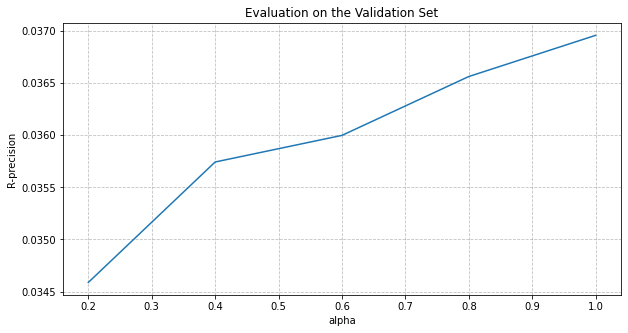

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(evaluation.keys(), evaluation.values())
ax.set_title('Evaluation on the Validation Set')
ax.set_ylabel('R-precision')
ax.set_xlabel('alpha')
plt.grid(alpha = 0.5, color = 'grey', linestyle = '--')
plt.show()

Fitting the model with this alpha

In [24]:
alpha = sorted(evaluation.items(), key = lambda x: x[1], reverse = True)[0][0]
model = SimilarityModel(tracks_subset, train)
model.fit(alpha = alpha)        

### Let's see in the testing ad training set

I only have to set test index to `playlist_id` because it is only done automatically in the training set. 

In [25]:
test = test.set_index('playlist_id')

### Change the rate of known songs 

We were considering we already knew 70% tracks of the playlist. I vary this with some values to understang the results. 

In [26]:
rates = [0.2, 0.5, 0.7, 0.9]
evaluation = {'Rate': rates, 
              'Train Set': [], 
              'Test Set': []}
for rate in rates: 
    train_acc = model.accuracy_evaluation(rate = rate)
    test_acc = model.accuracy_evaluation(test, rate = rate, bar_show = False)
    evaluation['Train Set'].append(train_acc)
    evaluation['Test Set'].append(test_acc)

evaluation = pd.DataFrame(evaluation, index = range(4))

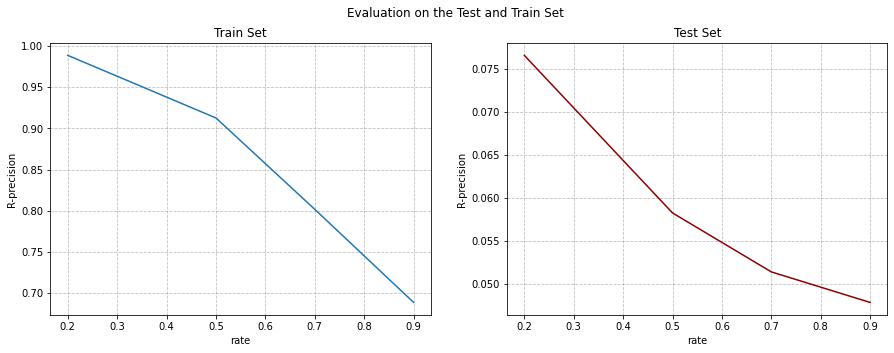

In [27]:
fig, ax = plt.subplots(1,2,figsize = (15, 5))

sns.lineplot(x = 'Rate', y = 'Train Set', data = evaluation, ax = ax[0])
sns.lineplot(x = 'Rate', y = 'Test Set', data = evaluation, ax = ax[1], color = 'darkred')

fig.suptitle('Evaluation on the Test and Train Set')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
ax[0].set_ylabel('R-precision')
ax[1].set_ylabel('R-precision')
ax[0].set_xlabel('rate')
ax[1].set_xlabel('rate')

ax[0].grid(alpha = 0.5, color = 'grey', linestyle = '--')
ax[1].grid(alpha = 0.5, color = 'grey', linestyle = '--')
plt.show()